<img src="https://www.syracuse.edu/wp-content/themes/g6-carbon/img/syracuse-university-seal.svg?ver=6.3.9" style="width: 300px;"/>

# Evolutionary Machine Learning - ML101
## CIS600 - Homework 1
## Author - Sanup Araballi
### Back-Propogation Approach
##### Hello World!
###### Disclaimer: 
1. I have used Titanic Dataset. 
2. I have referred to few blogs on GitHub and have based my solutions on them.
3. The graphs are referred from official python/keras website
4. The design of the models, playing around with the layers and the shape of layers and node along with data preparation part is by me.

In [1]:
#Machine Learning 101 - Using Keras model
import keras as ks
import numpy as np
import time
import pandas as pa

from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

# For plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.pylab import rcParams

import os

matplotlib.style.use('ggplot')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


### First get the data from the files and prepare them to be extracted as feature set. Drop the columns which are not adding value to feature set and clean the data to keep only numerical values.

In [2]:
#Get data and prepare data
ttd_train = pa.read_csv('Train.csv', header = 0)
ttd_test = pa.read_csv('Test.csv', header = 0)

In [3]:
#Check Training Data
ttd_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Check Testing Data
ttd_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#Drop the irrelevent columns
ttd_train.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], 1, inplace=True)
ttd_test.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], 1, inplace=True)
ttd_train.head()
ttd_test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,34.5,0,0,Q
1,3,female,47.0,1,0,S
2,2,male,62.0,0,0,Q
3,3,male,27.0,0,0,S
4,3,female,22.0,1,1,S


In [6]:
#Describe the training data to see stats
ttd_train.describe()

,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594
std,0.486592,0.836071,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000


### Define functions to change strings to numerical values

In [7]:
#Defind functions to convert gender and embarked to numerical values
def convGender(gen):
    if gen == 'female':
        return 0
    elif gen == 'male' :
        return 1
    else:
        return 2

def convEmbarked(emb):
    if emb == 'S':
        return 0
    elif emb == 'C':
        return 1
    elif emb == 'Q':
        return 2
    else:
        return 3

### Define function to plot a live graph for the epochs being executed. 

In [8]:
#Define a plot_loss function to plot a live graph against epoch runs
class PlotLosses(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [9]:
#Drop rows where age is blank
ttd_train.dropna(subset=['Age'], inplace=True)
ttd_test.dropna(subset=['Age'], inplace=True)

In [10]:
#Call the defined functions to change gender and embarked values
ttd_train['Embarked'] = ttd_train.apply(lambda row: convEmbarked(row['Embarked']), axis=1)
ttd_train['Sex'] = ttd_train.apply(lambda row: convGender(row['Sex']), axis=1)
ttd_test['Embarked'] = ttd_test.apply(lambda row: convEmbarked(row['Embarked']), axis=1)
ttd_test['Sex'] = ttd_test.apply(lambda row: convGender(row['Sex']), axis=1)

In [11]:
#Final check on data
ttd_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,22.0,1,0,0
1,1,1,0,38.0,1,0,1
2,1,3,0,26.0,0,0,0
3,1,1,0,35.0,1,0,0
4,0,3,1,35.0,0,0,0


In [12]:
ttd_test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1,34.5,0,0,2
1,3,0,47.0,1,0,0
2,2,1,62.0,0,0,2
3,3,1,27.0,0,0,0
4,3,0,22.0,1,1,0


### Split data into train and test

In [13]:
#Split the training data into x and y along with some test samples.
from sklearn.model_selection import train_test_split
x = ttd_train.drop('Survived', axis=1)
y = ttd_train['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

### I have build the model as a convex shape instead of a convergence from the 1st hidden layer. This has helped me to improve accuracy significantly and consistently(70% and above).

In [14]:
#Neural Network Model - First tried a convergence model
#After multiple trials, have updated the model shape to a convex shape. Seems to be improving accuracy!

model = Sequential()
model.add(Dense(8, input_dim = 6, activation='sigmoid'))
model.add(Dropout(0.01))
#Keeping the relu layers to check the difference in output.
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.01))
model.add(Dense(1, activation='sigmoid'))

#Compile the model and print summary
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 56        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
__________

### Run the ML using Keras and get the results into a variable to be used to for plotting graphs later.

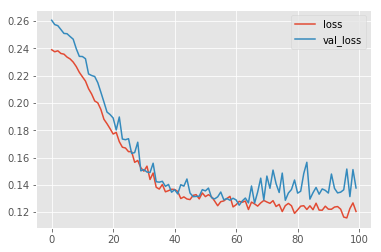

Time taken to train the model:  23.26814889907837 secs


In [15]:
# Train the model along with validating the data as well. 
# Also plot live Epoch Vs Loss graph
t0 = time.time()
result = model.fit(x_train, y_train, epochs=100, batch_size=32, shuffle=True, validation_split = 0.1, callbacks = [plot_losses])
t1 = time.time()

print("Time taken to train the model: ", t1-t0, "secs")

### Do the prediction on the test data prepared.

In [16]:
#Do the prediction on the test data created initially. Convert the data for comparison
#Here the arbitrary value chosen is 0.5 for differentiating the result

y_predict = model.predict(x_test)
#print(y_predict)
#y_predict = y_predict.apply(lambda row: convResult(), axis=1)
i = 0
while i < len(y_predict):
    if y_predict[i][0] < 0.5:
        y_predict[i][0] = 0
    else:
        y_predict[i][0] = 1
    i += 1

#print(y_predict)

### Create and print confusion matrix along with accuracy score

In [17]:
#Create and print confusion matrix along with accuracy score
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predict)
print(conf_matrix)

acc = accuracy_score(y_test, y_predict)
print('Accuracy Score: ', acc, '\n')

[[35  5]
 [11 21]]
Accuracy Score:  0.7777777777777778 



In [18]:
#Trying out the same model on the test.csv file. But there is no means of validating the data.
ttd_predict = model.predict(ttd_test)
i = 0
while i < len(ttd_predict):
    if ttd_predict[i][0] < 0.5:
        ttd_predict[i][0] = 0
    else:
        ttd_predict[i][0] = 1
    i += 1

### Plot graphs.

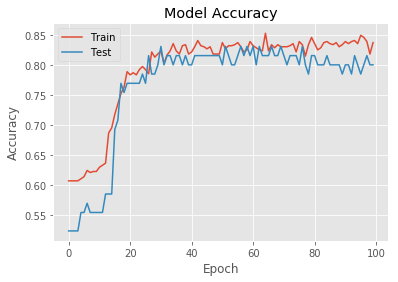

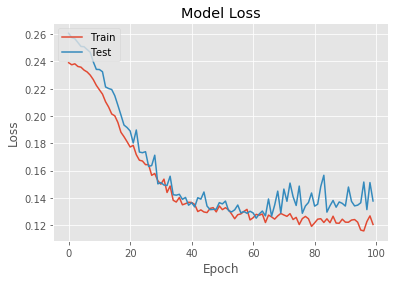

In [19]:
# Plot training & validation accuracy values
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()